In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Conv2D
from tensorflow.keras.models import load_model, Model
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body,yolo_eval
import yolo_utils


In [2]:
yolo_model = load_model("model_data/yolo.h5")
#加载预训练模型以及参数,也可yolo_model = yolo_body(,,,)

In [20]:
class_names = yolo_utils.read_classes("model_data/coco_classes.txt")
anchors = yolo_utils.read_anchors("model_data/yolo_anchors.txt")
#读取anchor box,class
image_shape = (600.,900.)
#原图像大小，用于预测的相对位置递推原位置
image,image_data = yolo_utils.preprocess_image("images/timg.jpg", model_image_size = (608, 608))
num_classes = len(class_names)
yolo_outputs = yolo_model(image_data)
#模型输出(n,19,19,425) 425为5个anchor box×(5个x,y,w,h,pc + 80个类别)
yolo_outputs = yolo_head(yolo_outputs, anchors, num_classes)
box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
boxes = yolo_boxes_to_corners(box_xy, box_wh)

In [21]:
box_scores = box_confidence * box_class_probs
#存在东西的概率×是某类型的概率 = 某类型存在的概率

In [22]:
box_classes = K.argmax(box_scores, axis=-1)
#80个类别中最大概率的index

In [23]:
box_class_scores = K.max(box_scores, axis=-1)
#结合所有类型存在的概率，测算最大概率的类型

In [24]:
prediction_mask = box_class_scores >= 0.6
#概率低于0.6为false,否则为true

In [25]:
boxes = tf.boolean_mask(boxes, prediction_mask)
scores = tf.boolean_mask(box_class_scores, prediction_mask)
classes = tf.boolean_mask(box_classes, prediction_mask)
#筛选去掉概率低的box

In [29]:
height = image_shape[0]
width = image_shape[1]
image_dims = K.stack([height, width, height, width])
image_dims = K.reshape(image_dims, [1, 4])
boxes = boxes * image_dims
#恢复在原图尺寸

In [30]:
nms_index = tf.image.non_max_suppression(boxes, scores, 10, iou_threshold=0.5)
#非极大抑制算法进一步过滤box
boxes = K.gather(boxes, nms_index)
scores = K.gather(scores, nms_index)
classes = K.gather(classes, nms_index)

car 0.61 (443, 274) (569, 404)
car 0.70 (405, 295) (471, 349)
car 0.74 (470, 245) (869, 493)
car 0.74 (301, 275) (424, 378)
car 0.80 (4, 281) (353, 526)


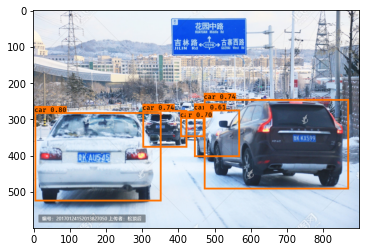

In [31]:
colors = yolo_utils.generate_colors(class_names)

yolo_utils.draw_boxes(image, scores, boxes, classes, class_names, colors)

plt.imshow(image)